# Identify RSMs using an ANN-bsed prototype from ANN model with random connectivity (shuffled weights)

#### Takuya Ito
#### 05/15/2019

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
import scipy.stats as stats
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
import h5py
import tools
import nibabel as nib
from importlib import reload
import sklearn
import pandas as pd

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "FreeSans"


In [14]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']



projectdir = '/home/ti61/f_mc1689_1/SRActFlow/'

# Using final partition
networkdef = np.loadtxt(projectdir + 'data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'vmm':11, 'ora':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = projectdir + 'data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

## Load RSMs containing rule and stimulus activations.. otherwise create it

In [15]:
# Shouldn't need to execute -- data already exists
if os.path.exists('../../data/results/MAIN/RSA/EmpiricalRSMs_allParcels.h5'):
    print('Empirical RSMs exist already... skipping')
    h5f = h5py.File('../../data/results/MAIN/RSA/EmpiricalRSMs_allParcels.h5','r')
    group_rsm = h5f['data'][:].copy()
    h5f.close()

else:
    
    # gsr = True
    n_features = 28 # 12 rules, 16 stim combos
    data_task = np.zeros((len(glasser2),n_features,len(subjNums)))
    rules = ['Logic','Sensory','Motor']
    stimuli = ['colorStim','oriStim','pitchStim','constantStim']


    scount = 0
    for subj in subjNums:
        print('Loading subject', subj)
        indstart = 0
        indend = 4
        for rule in rules:
            data_task[:,indstart:indend,scount] = tools.loadRuleEncoding(subj,rule)
            indstart += 4
            indend += 4

        for stim in stimuli:
            data_task[:,indstart:indend,scount] = tools.loadInputActivity(subj,stim)
            indstart += 4
            indend += 4

        scount += 1
    
    ####
    # Create group RSMs
    group_rsm = np.zeros((n_features, n_features, nParcels))

    group_data_task = np.mean(data_task,axis=2)
    for parcel in range(nParcels):
        parcel_ind = np.where(glasser2==parcel+1)[0]
        tmp = np.corrcoef(group_data_task[parcel_ind,:].T)
        np.fill_diagonal(tmp,0)
        tmp = np.arctanh(tmp)
        group_rsm[:,:,parcel] = tmp.copy()

    ####
    # Write to file
    h5f = h5py.File('../../data/results/MAIN/RSA/EmpiricalRSMs_allParcels.h5','a')
    try:
        h5f.create_dataset('data',data=group_rsm)
    except:
        del h5f['data']
        h5f.create_dataset('data',data=group_rsm)
    h5f.close()
  

Empirical RSMs exist already... skipping


#### Run RSA and construct RSM

In [16]:
n_features = 28
# ann_rsm = np.loadtxt(projectdir + 'data/results/MODEL/ANN1280_HiddenLayerRSM_NoDynamics_ShuffledConn.csv')
ann_rsm = np.loadtxt(projectdir + 'data/results/MODEL/ANN1280_HiddenLayerRSM_NoDynamics_ShuffledConn.csv')
triu_ind = np.triu_indices(n_features,k=1)
rsm_similarities = np.zeros((nParcels,3)) # r, p, q
# group_rsm = np.mean(rsm,axis=3)
for parcel in range(nParcels):
#     r, p = stats.pearsonr(np.arctanh(ann_rsm[triu_ind]),group_rsm[:,:,parcel][triu_ind])
    r, p = stats.spearmanr(np.arctanh(ann_rsm[triu_ind]),group_rsm[:,:,parcel][triu_ind])
    rsm_similarities[parcel,0] = r
    rsm_similarities[parcel,1] = p
rsm_similarities[:,2] = mc.fdrcorrection0(rsm_similarities[:,1])[0]
    
    
max_ind = np.where(rsm_similarities[:,0]==np.max(rsm_similarities[:,0]))[0]
min_ind = np.where(rsm_similarities[:,0]==np.min(rsm_similarities[:,0]))[0]
print('Max RSM similarity:', np.max(rsm_similarities[:,0]), 'ROI =', max_ind+1)
print('Min RSM similarity:', np.min(rsm_similarities[:,0]), 'ROI =', min_ind+1)


Max RSM similarity: 0.21119699556602475 ROI = [118]
Min RSM similarity: -0.17121845390428778 ROI = [206]


#### Create histogram of entire distribution of similarities scores

/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean of similarities scores: 0.015027306266955393
Median of similarities scores: 0.016999227384043025


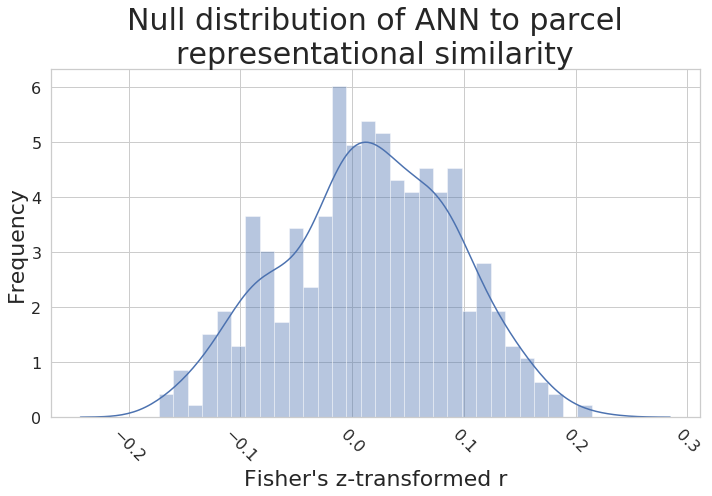

In [18]:
df_histogram = {}
df_histogram['Similarity'] = []
df_histogram['ROI'] = []
for roi in range(nParcels):
    df_histogram['Similarity'].append(np.arctanh(rsm_similarities[roi,0]))
    df_histogram['ROI'].append(roi)
        
df_histogram = pd.DataFrame(df_histogram)
    
plt.figure(figsize=(10,7))
ax = sns.distplot(df_histogram['Similarity'].values,30)
plt.title('Null distribution of ANN to parcel\nrepresentational similarity',fontsize=30);
plt.xlabel("Fisher's z-transformed r",fontsize=22);
plt.ylabel('Frequency',fontsize=22);
plt.xticks(fontsize=16,rotation=-45);
plt.yticks(fontsize=16);
# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[-12:], labels[-12:], borderaxespad=0., bbox_to_anchor=(1.05, 1), prop={'size': 12})
# plt.legend()
plt.tight_layout()
# plt.savefig('HiddenlayerRSA_SimilarityHistogram_NullShuffledParams.png',dpi=300)
print('Mean of similarities scores:', np.mean(df_histogram.Similarity.values))
print('Median of similarities scores:', np.median(df_histogram.Similarity.values))


write = False
if write:
    with pd.ExcelWriter("../../data/NatComms_SourceData.xlsx",mode='a', engine="openpyxl") as writer:
        df_rsm_networks.to_excel(writer,sheet_name='SFig4')

/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


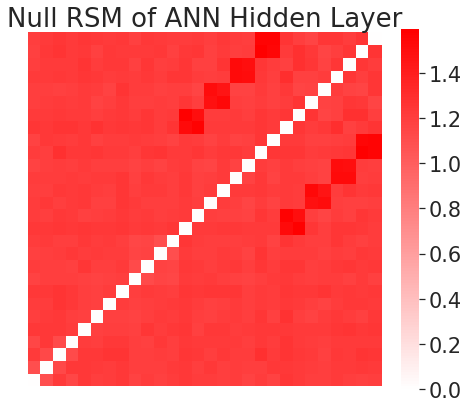

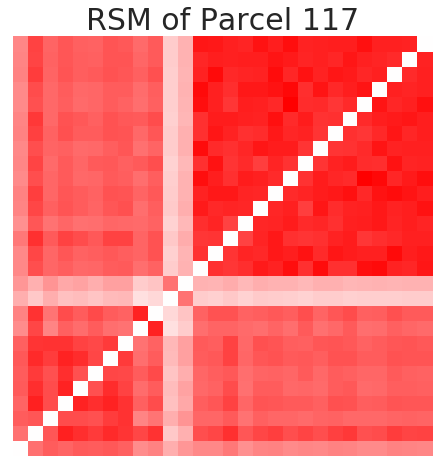

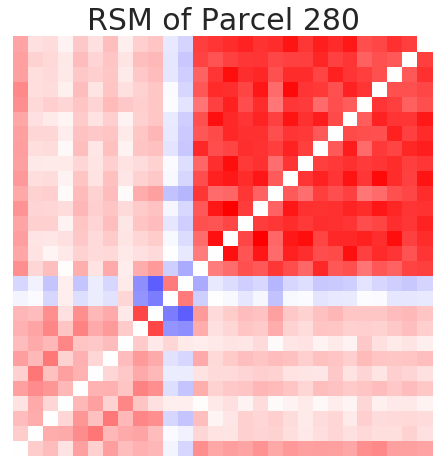

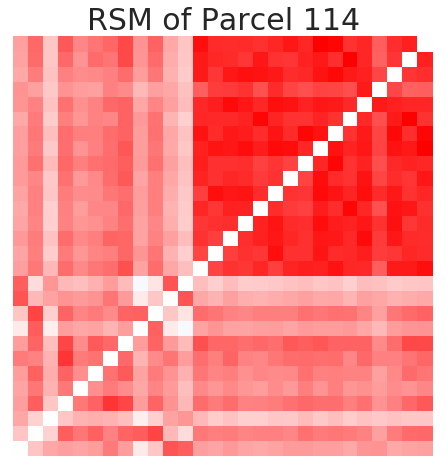

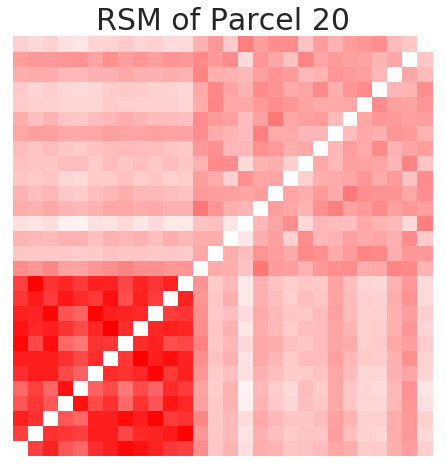

In [9]:
plt.figure(figsize=(7,7))
# ax = sns.heatmap(np.arctanh(ann_rsm),cmap='bwr', center=0,square=True,cbar_kws={'fraction':0.046},xticklabels=False,yticklabels=False)
sns.set(font_scale=1.9)
ax = sns.heatmap(np.arctanh(ann_rsm),cmap='bwr', center=0,square=True,xticklabels=False,yticklabels=False,cbar=True,cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.title("Null RSM of ANN Hidden Layer", fontsize=26, fontname="Arial")
plt.tight_layout()
# plt.savefig('RSM_ANN_HiddenLayer_NullShuffledParams.png', dpi=300)


plt.figure(figsize=(7,7))
parcelno = 116
# ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046},xticklabels=False,yticklabels=False)
ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',xticklabels=False,yticklabels=False,cbar=False)
ax.invert_yaxis()
plt.title("RSM of Parcel " + str(parcelno+1), fontsize=30, fontname="Arial")
plt.tight_layout()
# plt.savefig('RSM_Parcel' + str(parcelno+1) + '.png', dpi=300)


plt.figure(figsize=(7,7))
parcelno = 279
# ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046},xticklabels=False,yticklabels=False)
ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',xticklabels=False,yticklabels=False,cbar=False)
ax.invert_yaxis()
plt.title("RSM of Parcel " + str(parcelno+1), fontsize=30, fontname="Arial")
plt.tight_layout()
# plt.savefig('RSM_Parcel' + str(parcelno+1) + '.png', dpi=300)

plt.figure(figsize=(7,7))
parcelno = 113
# ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046},xticklabels=False,yticklabels=False)
ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',xticklabels=False,yticklabels=False,cbar=False)
ax.invert_yaxis()
plt.title("RSM of Parcel " + str(parcelno+1), fontsize=30, fontname="Arial")
plt.tight_layout()
# plt.savefig('RSM_Parcel' + str(parcelno+1) + '.png', dpi=300)


plt.figure(figsize=(7,7))
parcelno = 19
# ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046},xticklabels=False,yticklabels=False)
ax = sns.heatmap(group_rsm[:,:,parcelno],square=True,center=0,cmap='bwr',xticklabels=False,yticklabels=False,cbar=False)
ax.invert_yaxis()
plt.title("RSM of Parcel " + str(parcelno+1), fontsize=30, fontname="Arial")
plt.tight_layout()
# plt.savefig('RSM_Parcel' + str(parcelno+1) + '.png', dpi=300)

